In [29]:

!pip install scikit-optimize

In [30]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, make_scorer, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from numpy.lib.stride_tricks import sliding_window_view


from skopt import BayesSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

---
## Preprocesado
---
Identico al del de Treball Previ para LR y añadiendo requisitos especificos de KNN y SVM Poly (estandarización y one-hot)

In [31]:
time_for_pred = 24

In [32]:
# Cargar el conjunto de datos
data = pd.read_csv('dataset.csv')

# Crear características 'lagged'
for i in range(1, 2):
    data[f'lag_{i}'] = data['exits'].shift(i)

data['demand_satisfied_lag'] = data['demand_satisfied'].shift(1)
data = data.drop('demand_satisfied', axis=1)

# Crear una columna de fecha a partir de las columnas de año, mes y día
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

# Filtrar datos entre las fechas especificadas
start_date = pd.Timestamp('2022-01-01')
end_date = pd.Timestamp('2023-11-30')
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

data = data.drop('date', axis=1)

In [33]:
from sklearn.model_selection import train_test_split

split_index = int(len(data) - time_for_pred)

# Divide los datos en conjuntos de entrenamiento y prueba según el índice calculado
data_train = data.iloc[:split_index]
data_test = data.iloc[split_index:]

# data_train, data_test = train_test_split(data, test_size=0.1, shuffle=False)

data_train.shape, data_test.shape

((16752, 17), (24, 17))

In [34]:
from sklearn.impute import KNNImputer
data_imputer = data_train.drop('exits', axis=1)

knni_demand_satisfied_lag = KNNImputer(n_neighbors=10)
knni_initial_bikes = KNNImputer(n_neighbors=10)

i_demand_satisfied_lag = knni_demand_satisfied_lag.fit_transform(data_imputer)[:,-1]
i_initial_bikes = knni_initial_bikes.fit_transform(data_imputer)[:, 13]

# Redondear y convertir a enteros las columnas
i_demand_satisfied_lag = i_demand_satisfied_lag.round().astype(int)
i_initial_bikes = i_initial_bikes.round().astype(int)

data_train['demand_satisfied_lag'] = i_demand_satisfied_lag
data_train['initial_bikes'] = i_initial_bikes

<ipython-input-34-dab25ab3a451>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['demand_satisfied_lag'] = i_demand_satisfied_lag
<ipython-input-34-dab25ab3a451>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['initial_bikes'] = i_initial_bikes


In [35]:
data_imputer = data_test.drop('exits', axis=1)

i_demand_satisfied_lag = knni_demand_satisfied_lag.transform(data_imputer)[:,-1]
i_initial_bikes = knni_initial_bikes.transform(data_imputer)[:, 13]

# Redondear y convertir a enteros las columnas
i_demand_satisfied_lag = i_demand_satisfied_lag.round().astype(int)
i_initial_bikes = i_initial_bikes.round().astype(int)

data_test['demand_satisfied_lag'] = i_demand_satisfied_lag
data_test['initial_bikes'] = i_initial_bikes

<ipython-input-35-39500e2f055e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['demand_satisfied_lag'] = i_demand_satisfied_lag
<ipython-input-35-39500e2f055e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['initial_bikes'] = i_initial_bikes


---
# **Aplicacion de los modelos**
---



In [36]:
results_df = pd.DataFrame(columns=['Model', 'R2 Score', 'MSE', 'RMSE', 'MAE'])

## **Linear Regresion**

In [37]:
X_train_lr = data_train.drop('exits', axis=1)
y_train_lr = data_train['exits']

X_test_lr = data_test.drop('exits', axis=1)
y_test_lr = data_test['exits']

In [38]:
from cmath import sqrt

# Create the linear regression model
linear_reg = LinearRegression()

# Fit the model on the training data
linear_reg.fit(X_train_lr, y_train_lr)

# Predict on the test data
y_pred_lr = linear_reg.predict(X_test_lr)

# Evaluate the model on the test set
r2_score_lr = linear_reg.score(X_test_lr, y_test_lr)
mse = mean_squared_error(y_test_lr, y_pred_lr)
mae = mean_absolute_error(y_test_lr, y_pred_lr)

# Add the results to the dataframe
results_df.loc[0] = ["Linear Regression", r2_score_lr, mse, sqrt(mse), mae]

results_df


,Model,R2 Score,MSE,RMSE,MAE
0,Linear Regression,0.605522,12.518509,3.53815+0.00000j,2.568729


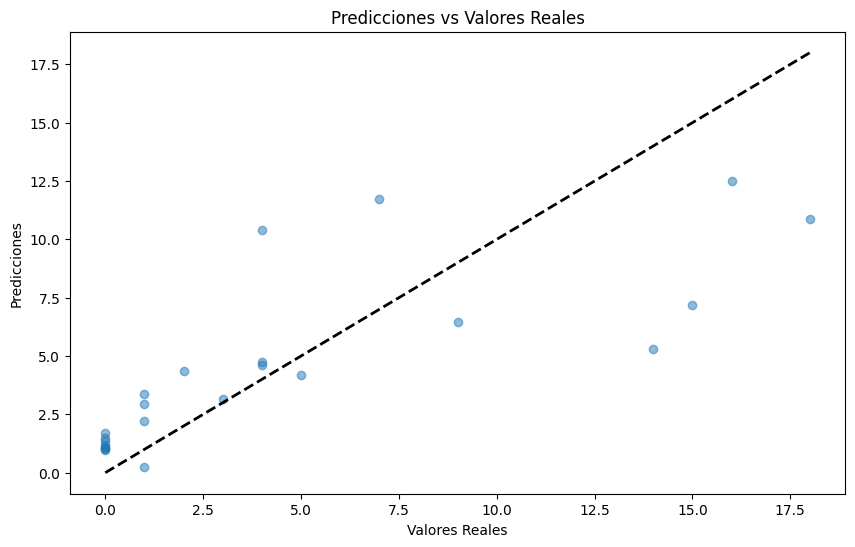

In [39]:
# Realizar el gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_lr, y_pred_lr, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test_lr.min(), y_test_lr.max()], [y_test_lr.min(), y_test_lr.max()], 'k--', lw=2)  # Línea de perfecta predicción
plt.show();

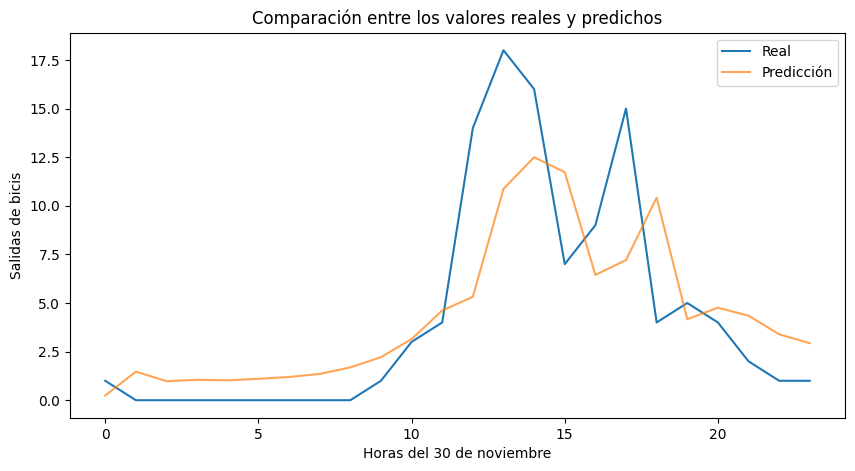

In [40]:
# Graficar los valores reales vs. los predichos
plt.figure(figsize=(10, 5))
plt.plot(y_test_lr.reset_index(drop=True), label='Real')
plt.plot(y_pred_lr, label='Predicción', alpha=0.7)
plt.title('Comparación entre los valores reales y predichos')
plt.xlabel('Horas del 30 de noviembre')
plt.ylabel('Salidas de bicis')
plt.legend()
plt.show();

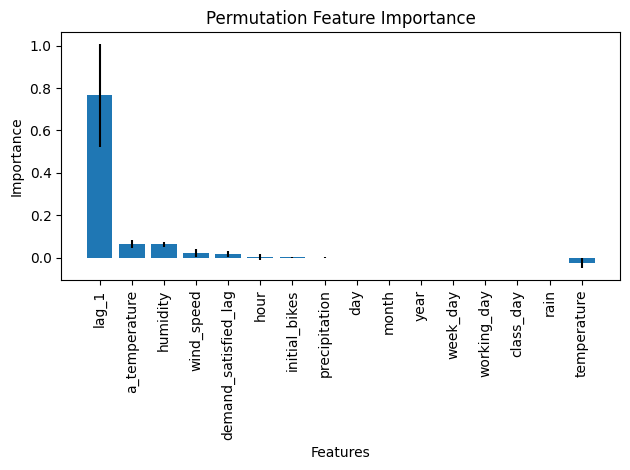

In [41]:
from sklearn.inspection import permutation_importance

# Realizar la importancia de permutación en el conjunto de prueba
perm_importance = permutation_importance(linear_reg, X_test_lr, y_test_lr, n_repeats=10, random_state=0)

# Obtener importancias medias y desviaciones estándar
importances_mean = perm_importance.importances_mean
importances_std = perm_importance.importances_std

# Crear un DataFrame para visualizar la importancia de las características
feature_names = X_train_lr.columns
df_importances = pd.DataFrame({'feature': feature_names, 'importance_mean': importances_mean, 'importance_std': importances_std})

# Ordenar las características por importancia
df_importances = df_importances.sort_values(by='importance_mean', ascending=False)

# Visualizar la importancia de las características
plt.bar(df_importances['feature'], df_importances['importance_mean'], yerr=df_importances['importance_std'])
plt.xticks(rotation=90)
plt.title('Permutation Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()  # Ajustar automáticamente los parámetros para que el gráfico quede bien
plt.show()

### **K-Nearest Neighbours**

Per KNN cal normalitzar les variables numeriques i fer one-hot encoding de les variables categoriques

In [42]:
from sklearn.preprocessing import StandardScaler

data = pd.concat([data_train, data_test], ignore_index=True)

# Select the categorical variables for one-hot encoding
categorical_vars_selected = ["hour", "day", "month", "year", "week_day", "working_day", "class_day","demand_satisfied_lag"]

# Perform one-hot encoding on the selected categorical variables
data_knn = pd.get_dummies(data, columns=categorical_vars_selected)

data_knn.head()


data_train_knn = data_knn.iloc[:split_index]
data_test_knn = data_knn.iloc[split_index:]

numeric_vars_without_exits = ["temperature", "a_temperature", "precipitation", "wind_speed", "humidity","initial_bikes","lag_1"]

scaler = StandardScaler()

data_train_knn[numeric_vars_without_exits] = scaler.fit_transform(data_train_knn[numeric_vars_without_exits])
data_test_knn[numeric_vars_without_exits] = scaler.transform(data_test_knn[numeric_vars_without_exits])

X_train_knn = data_train_knn.drop('exits', axis=1)
y_train_knn = data_train_knn['exits']

X_test_knn = data_test_knn.drop('exits', axis=1)
y_test_knn = data_test_knn['exits']


<ipython-input-42-178ab3198b82>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_knn[numeric_vars_without_exits] = scaler.fit_transform(data_train_knn[numeric_vars_without_exits])
<ipython-input-42-178ab3198b82>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_knn[numeric_vars_without_exits] = scaler.transform(data_test_knn[numeric_vars_without_exits])


In [43]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

param_space_knn = {
    'n_neighbors': (3, 20),
    'weights': ['uniform', 'distance'],
    'leaf_size' : [20,30,40],
    'p': [1, 2]
}

# Create the KNN model
knn = KNeighborsRegressor()

# Configure TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3, gap=25)

# Configure BayesSearchCV for KNN
knn_bs = BayesSearchCV(
    knn,
    param_space_knn,
    n_iter=30,
    cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),  # Note: BayesSearchCV uses neg_mean_squared_error for optimization
    n_jobs=-1,
    refit=True,
    random_state=0
)

# Fit the KNN model with BayesSearchCV
knn_bs.fit(X_train_knn, y_train_knn)

# Best model and parameters found
best_knn_bs = knn_bs.best_estimator_
best_params_knn_bs = knn_bs.best_params_

# Evaluate the model on the test set
y_pred_knn_bs = best_knn_bs.predict(X_test_knn)
r2_score_knn_bs = r2_score(y_test_knn, y_pred_knn_bs)

# Print the best parameters and R2 score for KNN with BayesSearchCV
print("Best parameters for KNN (BayesSearchCV):", best_params_knn_bs)
mse_knn_bs = mean_squared_error(y_test_knn, y_pred_knn_bs)
mae_knn_bs = mean_absolute_error(y_test_knn, y_pred_knn_bs)

# Assuming you have a DataFrame named results_df
results_df.loc[1] = ["K-Nearest Neighbors", r2_score_knn_bs, mse_knn_bs, sqrt(mse_knn_bs), mae_knn_bs]

# Print or use results_df as needed
print(results_df)



Best parameters for KNN (BayesSearchCV): OrderedDict([('leaf_size', 40), ('n_neighbors', 12), ('p', 1), ('weights', 'distance')])
                 Model  R2 Score        MSE                RMSE       MAE
0    Linear Regression  0.605522  12.518509  3.538150+0.000000j  2.568729
1  K-Nearest Neighbors  0.825553   5.535981  2.352866+0.000000j  1.553619


In [44]:
results_df

,Model,R2 Score,MSE,RMSE,MAE
0,Linear Regression,0.605522,12.518509,3.538150+0.000000j,2.568729
1,K-Nearest Neighbors,0.825553,5.535981,2.352866+0.000000j,1.553619


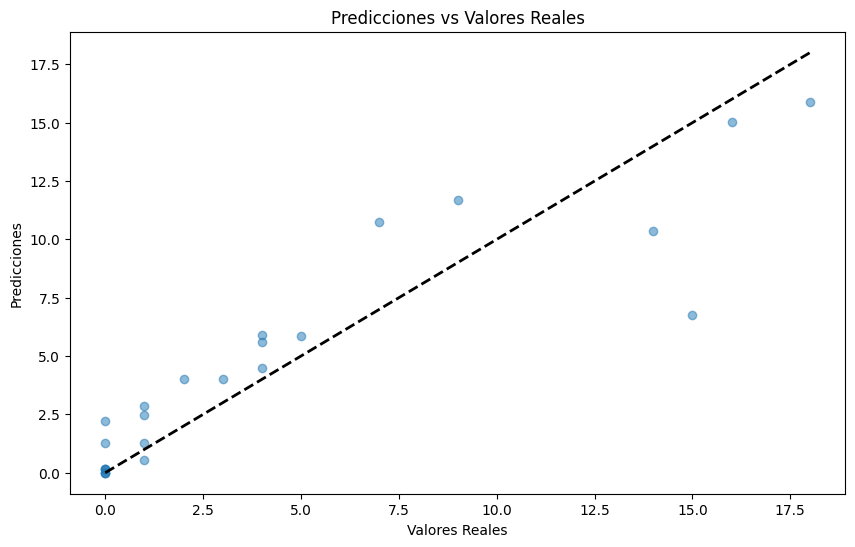

In [45]:
# Realizar el gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_knn, y_pred_knn_bs, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test_knn.min(), y_test_knn.max()], [y_test_knn.min(), y_test_knn.max()], 'k--', lw=2)  # Línea de perfecta predicción
plt.show();

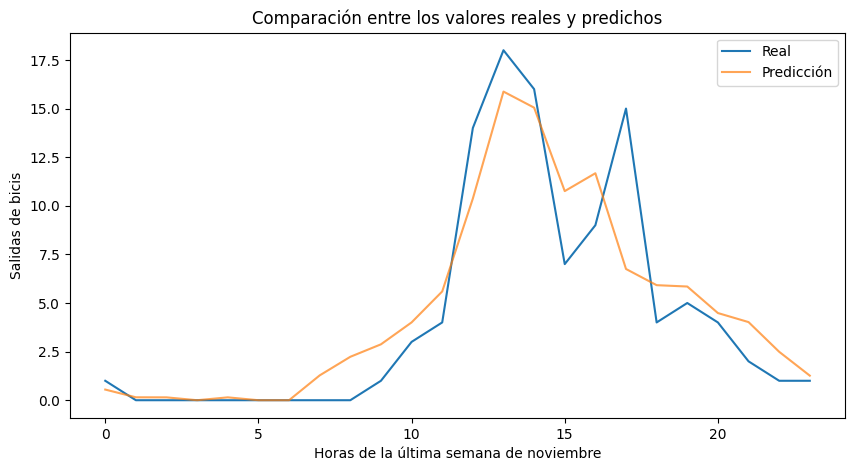

In [46]:
# Graficar los valores reales vs. los predichos
plt.figure(figsize=(10, 5))
plt.plot(y_test_knn.reset_index(drop=True), label='Real')
plt.plot(y_pred_knn_bs, label='Predicción', alpha=0.7)
plt.title('Comparación entre los valores reales y predichos')
plt.xlabel('Horas de la última semana de noviembre')
plt.ylabel('Salidas de bicis')
plt.legend()
plt.show();

### **SVM con Kernel POLY**

Para este modelo necesitaremos lo mismo que para KNN, one-hot encoding y datos normalizados, por lo tanto podemos usar el mismo procesamiento.

In [47]:
data = pd.concat([data_train, data_test], ignore_index=True)

# Select the categorical variables for one-hot encoding
categorical_vars_selected = ["hour", "day", "month", "year", "week_day", "working_day", "class_day","demand_satisfied_lag"]

# Perform one-hot encoding on the selected categorical variables
data_svm = pd.get_dummies(data, columns=categorical_vars_selected)

data_svm.head()


data_train_svm = data_svm.iloc[:split_index]
data_test_svm = data_svm.iloc[split_index:]

numeric_vars_without_exits = ["temperature", "a_temperature", "precipitation", "wind_speed", "humidity","initial_bikes","lag_1"]

data_train_svm[numeric_vars_without_exits] = scaler.fit_transform(data_train_svm[numeric_vars_without_exits])
data_test_svm[numeric_vars_without_exits] = scaler.transform(data_test_svm[numeric_vars_without_exits])

X_train_svm = data_train_svm.drop('exits', axis=1)
y_train_svm = data_train_svm['exits']

X_test_svm = data_test_svm.drop('exits', axis=1)
y_test_svm = data_test_svm['exits']

<ipython-input-47-7a52f075b4b1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_svm[numeric_vars_without_exits] = scaler.fit_transform(data_train_svm[numeric_vars_without_exits])
<ipython-input-47-7a52f075b4b1>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_svm[numeric_vars_without_exits] = scaler.transform(data_test_svm[numeric_vars_without_exits])


In [48]:
# Define the parameter search space for SVM with polynomial kernel
param_space_svm_poly = {
    'degree': (2, 4), # Grado del polinomio, de 2 a 4
    'C': [0.1, 0.5, 1.0, 5.0], #Es el parámetro de regularización, que controla la penalización por errores en la función de pérdida.
    'gamma': ['scale', 'auto', 1.0],
    'max_iter' : [-1,100,200]
}

# Create the SVM model with polynomial kernel
svm_poly = SVR(kernel='poly')

# Configure TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3, gap=25)

# Configure BayesSearchCV for SVM with polynomial kernel
svm_poly_bs = BayesSearchCV(
    svm_poly,
    param_space_svm_poly,
    n_iter=30,
    cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),  # Note: BayesSearchCV uses neg_mean_squared_error for optimization
    n_jobs=-1,
    refit=True,
    random_state=0
)

# Fit the SVM model with BayesSearchCV
svm_poly_bs.fit(X_train_svm, y_train_svm)

# Best model and parameters found
best_svm_poly_bs = svm_poly_bs.best_estimator_
best_params_svm_poly_bs = svm_poly_bs.best_params_

# Evaluate the model on the test set
y_pred_svm_poly_bs = best_svm_poly_bs.predict(X_test_svm)
r2_score_svm_poly_bs = r2_score(y_test_svm, y_pred_svm_poly_bs)

# Print the best parameters and R2 score for SVM with polynomial kernel using BayesSearchCV
print("Best parameters for SVM with polynomial kernel (BayesSearchCV):", best_params_svm_poly_bs)
mse_svm_poly_bs = mean_squared_error(y_test_svm, y_pred_svm_poly_bs)
mae_svm_poly_bs = mean_absolute_error(y_test_svm, y_pred_svm_poly_bs)

# Assuming you have a DataFrame named results_df
results_df.loc[2] = ["SVM with Polynomial Kernel", r2_score_svm_poly_bs, mse_svm_poly_bs, sqrt(mse_svm_poly_bs), mae_svm_poly_bs]

# Print or use results_df as needed
print(results_df)


Best parameters for SVM with polynomial kernel (BayesSearchCV): OrderedDict([('C', 5.0), ('degree', 2), ('gamma', 'auto'), ('max_iter', -1)])
                        Model  R2 Score        MSE                RMSE  \
0           Linear Regression  0.605522  12.518509  3.538150+0.000000j   
1         K-Nearest Neighbors  0.825553   5.535981  2.352866+0.000000j   
2  SVM with Polynomial Kernel  0.732322   8.494578  2.914546+0.000000j   

        MAE  
0  2.568729  
1  1.553619  
2  1.902806  


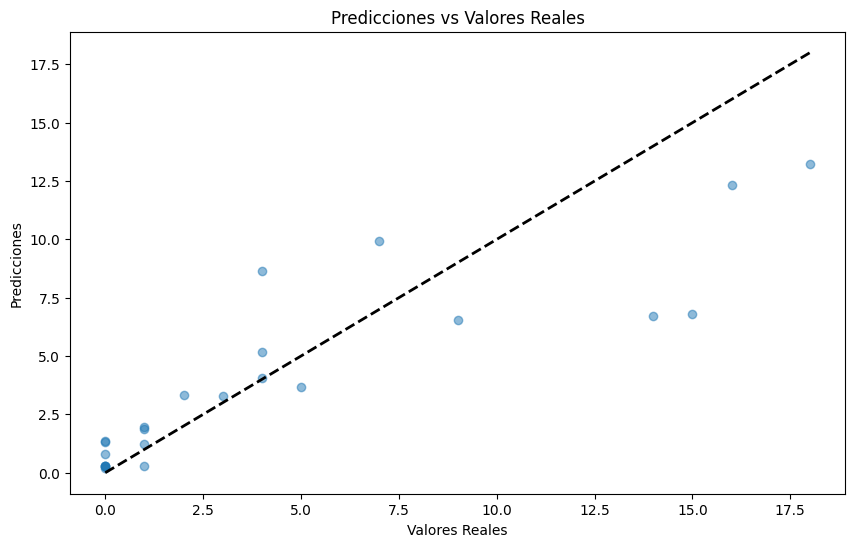

In [49]:
# Realizar el gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_knn, y_pred_svm_poly_bs, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
plt.plot([y_test_knn.min(), y_test_knn.max()], [y_test_knn.min(), y_test_knn.max()], 'k--', lw=2)  # Línea de perfecta predicción
plt.show();

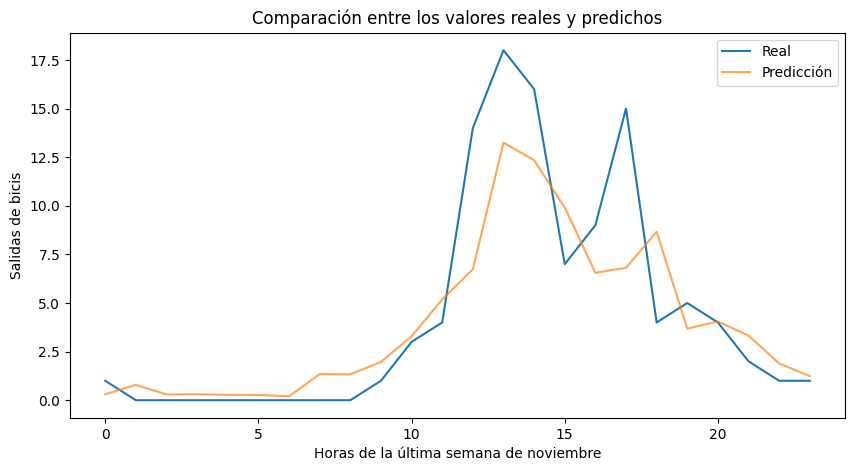

In [50]:
# Graficar los valores reales vs. los predichos
plt.figure(figsize=(10, 5))
plt.plot(y_test_knn.reset_index(drop=True), label='Real')
plt.plot(y_pred_svm_poly_bs, label='Predicción', alpha=0.7)
plt.title('Comparación entre los valores reales y predichos')
plt.xlabel('Horas de la última semana de noviembre')
plt.ylabel('Salidas de bicis')
plt.legend()
plt.show();